In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [2]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180
SPLIT = 0.2
CLASS_NUMBER = 5
EPOCHS = 10

In [43]:
def download_dataset(url, dir_name):
    data_dir = tf.keras.utils.get_file(dir_name, origin=url, untar=True)
    return pathlib.Path(data_dir)

In [55]:
def load_dataset(path):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    train = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        validation_split = SPLIT,
        subset = 'training',
        seed = 123,
        image_size = (IMG_HEIGHT, IMG_WIDTH),
        batch_size = BATCH_SIZE
    )
    
    validation = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        validation_split = SPLIT,
        subset = 'validation',
        seed = 123,
        image_size = (IMG_HEIGHT, IMG_WIDTH),
        batch_size = BATCH_SIZE
    )
    
    train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    validation = validation.cache().prefetch(buffer_size = AUTOTUNE)
    
    return train, validation

In [5]:
def normalization(train_dataset):
    normalization_layer = layers.experimental.preprocessing.Rescaling(1. / 255)
    normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_dataset))
    
    return image_batch, labels_batch

In [39]:
class ImageClassifier(tf.keras.Model):
    def __init__(self, num_classes = CLASS_NUMBER, units = 128, padding = 'same', activation = 'relu', flip = 'horizontal', rotation = 0.1, zoom = 0.1, dropout = 0.2):
        super(ImageClassifier, self).__init__()
        self.random_flip = layers.experimental.preprocessing.RandomFlip(flip,
                                                                       input_shape = (IMG_HEIGHT, 
                                                                                      IMG_WIDTH, 
                                                                                      3))
        self.random_rotation = layers.experimental.preprocessing.RandomRotation(rotation)
        self.random_zoom = layers.experimental.preprocessing.RandomZoom(zoom)
        self.normalization = layers.experimental.preprocessing.Rescaling(1. / 255, input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))
        self.conv2d_1 = layers.Conv2D(16, 3, padding = padding, activation = activation)
        self.conv2d_2 = layers.Conv2D(32, 3, padding = padding, activation = activation)
        self.conv2d_3 = layers.Conv2D(64, 3, padding = padding, activation = activation)
        self.max_pooling2d = layers.MaxPooling2D()
        self.dropout = layers.Dropout(dropout)
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(units, activation = activation)
        self.dense_2 = layers.Dense(num_classes)
        
    def call(self, inputs, training = False):
        x = self.random_flip(inputs)
        x = self.random_rotation(x)
        x = self.random_zoom(x)
        x = self.normalization(x)
        x = self.conv2d_1(x)
        x = self.max_pooling2d(x)
        x = self.conv2d_2(x)
        x = self.max_pooling2d(x)
        x = self.conv2d_3(x)
        x = self.max_pooling2d(x)
        x = self.dropout(x, training = training)
        x = self.flatten(x)
        x = self.dense_1(x)
        output = self.dense_2(x)
        
        return output

In [64]:
model = ImageClassifier()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build((None, IMG_HEIGHT, IMG_WIDTH, 3))

In [41]:
model.summary()

Model: "image_classifier_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_9 (RandomFlip)   multiple                  0         
_________________________________________________________________
random_rotation_9 (RandomRot multiple                  0         
_________________________________________________________________
random_zoom_9 (RandomZoom)   multiple                  0         
_________________________________________________________________
rescaling_9 (Rescaling)      multiple                  0         
_________________________________________________________________
conv2d_27 (Conv2D)           multiple                  448       
_________________________________________________________________
conv2d_28 (Conv2D)           multiple                  4640      
_________________________________________________________________
conv2d_29 (Conv2D)           multiple           

In [52]:
path = download_dataset("https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz", ""flowers/1/"")

228818944/228813984 [==============================] - 61s 0us/step


In [53]:
path

PosixPath('/home/morfi/.keras/datasets/flower_photos')

In [56]:
train, validation = load_dataset(path)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [65]:
history = model.fit(
    train,
    validation_data = validation,
    epochs = EPOCHS
)

Epoch 1/10
92/92 [==============================] - 47s 506ms/step - loss: 1.3657 - accuracy: 0.4070 - val_loss: 1.1567 - val_accuracy: 0.5068
Epoch 2/10
92/92 [==============================] - 51s 556ms/step - loss: 1.0928 - accuracy: 0.5562 - val_loss: 1.0531 - val_accuracy: 0.5886
Epoch 3/10
92/92 [==============================] - 50s 543ms/step - loss: 0.9781 - accuracy: 0.6151 - val_loss: 0.9132 - val_accuracy: 0.6444
Epoch 4/10
92/92 [==============================] - 52s 562ms/step - loss: 0.9063 - accuracy: 0.6519 - val_loss: 0.8953 - val_accuracy: 0.6567
Epoch 5/10
92/92 [==============================] - 51s 560ms/step - loss: 0.8284 - accuracy: 0.6836 - val_loss: 0.8868 - val_accuracy: 0.6649
Epoch 6/10
92/92 [==============================] - 51s 555ms/step - loss: 0.7882 - accuracy: 0.7020 - val_loss: 0.8517 - val_accuracy: 0.6744
Epoch 7/10
92/92 [==============================] - 49s 531ms/step - loss: 0.7417 - accuracy: 0.7136 - val_loss: 0.7515 - val_accuracy: 0.7071

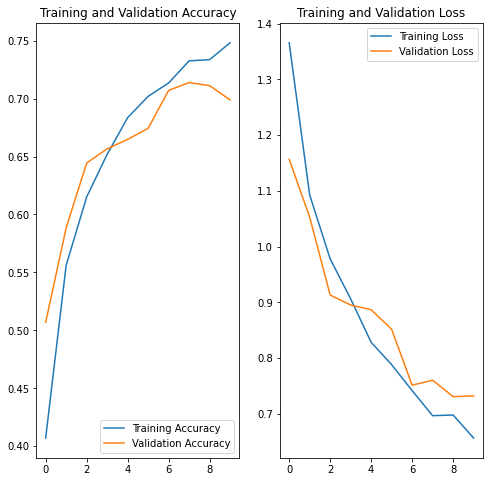

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 74.13 percent confidence.


In [77]:
tf.saved_model.save(model, "flowers/1/")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/flowers/1/assets


In [80]:
load_model = tf.saved_model.load(model_save_path)
print(list(load_model.signatures.keys()))

['serving_default']


In [85]:
infer = load_model.signatures['serving_default']

In [88]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

In [89]:
class_names[np.argmax(score)]

'sunflowers'